# Building Gene Regulatory Networks with BioCRNpyler
### _William Poole_

In this notebook, we will use RegulatedPromoter and CombinatorialPromoter to model Gene Regulation via Transcription Factors.

_Note: For this notebook to function, you need the default_parameter.txt file in the same folder as the notebook._

# Modeling Gene Regulation by a Single Transcription Factor
In biology, it is very common for a transcription factor to turn on or off promoter. BioCRNpyler has a number of Promoter Components to do this.
* RegulatedPromoter: A list of regulators each bind individually to turn a Promoter ON or OFF (No Combinatorial Logic)
* RepressiblePromoter: A single repressor modelled with a hill function
* ActivatablePromoter: A single activator modeled with a hill function

In the next example, we will produce and compare the outputs of these kinds of promoters.

# Example 1: ActivatablePromoter
A very simple Promoter Component modelled with a hill function. However, this class is not able to accurately capture the binding of Machinery like RNAP and shouldn't be used with Mixtures that include machinery.

In [1]:
from biocrnpyler import *

#ActivatedPromoter Example
activator = Species("activator", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":.01}
#By Loading custom parameters into the promoter, we override the default parameters of the Mixture
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly(name="activatable_assembly", promoter=P_activatable, rbs="Strong", protein = "A")

M = SimpleTxTlExtract(name="SimpleTxTl", parameter_file = "default_parameters.txt", components=[activatable_assembly])

CRN = M.compile_crn(); print(CRN)

Species = small_molecule_activator, protein_A, rna_activatable_assembly, dna_activatable_assembly
Reactions = [
	dna_activatable_assembly --> dna_activatable_assembly + rna_activatable_assembly        proportionalhillpositive: k(small_molecule_activator, dna_activatable_assembly)=1.0*dna_activatable_assembly*small_molecule_activator^4/(20+small_molecule_activator^4)
	dna_activatable_assembly --> dna_activatable_assembly + rna_activatable_assembly        massaction: k_f(dna_activatable_assembly)=0.01*dna_activatable_assembly
	rna_activatable_assembly --> rna_activatable_assembly + protein_A        massaction: k_f(rna_activatable_assembly)=0.25*rna_activatable_assembly
	rna_activatable_assembly -->         massaction: k_f(rna_activatable_assembly)=0.001*rna_activatable_assembly
]


C:\ProgramData\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


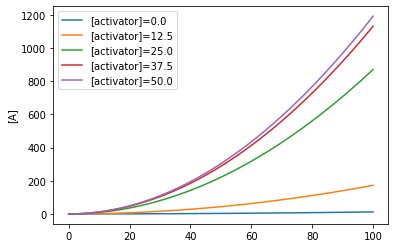

In [2]:
#Titrate the activator and plot the result
try:
    from biocrnpyler import *
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    for a_c in np.linspace(0, 50, 5):
        x0 = {str(activatable_assembly.dna):1, str(activator):a_c}
        timepoints = np.linspace(0, 100, 100)
        R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
        plt.plot(R["time"], R["protein_A"], label = "[activator]="+str(a_c))

    plt.ylabel("[A]")
    plt.legend()
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

# Example 2: RepressiblePromoter
A very simple Promoter Component modelled with a hill function. However, this class is not able to accurately capture the binding of Machinery like RNAP and shouldn't be used with Mixtures that include machinery.

In [3]:
#ActivatedPromoter Example
repressor = Species("A", material_type = "protein")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":.01}
#By Loading custom parameters into the promoter, we override the default parameters of the Mixture
P_repressible = RepressiblePromoter("P_repressible", repressor = repressor, leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
repressible_assembly = DNAassembly(name="reporter", promoter=P_repressible, rbs="Strong", protein = "reporter")

M = SimpleTxTlExtract(name="SimpleTxTl", parameter_file = "default_parameters.txt", components=[repressible_assembly])

CRN = M.compile_crn();print(CRN)

Species = rna_reporter, protein_A, dna_reporter, protein_reporter
Reactions = [
	dna_reporter --> dna_reporter + rna_reporter        proportionalhillnegative: k(protein_A, dna_reporter)=1.0*dna_reporter/(20+protein_A^4)
	dna_reporter --> dna_reporter + rna_reporter        massaction: k_f(dna_reporter)=0.01*dna_reporter
	rna_reporter --> rna_reporter + protein_reporter        massaction: k_f(rna_reporter)=0.25*rna_reporter
	rna_reporter -->         massaction: k_f(rna_reporter)=0.001*rna_reporter
]


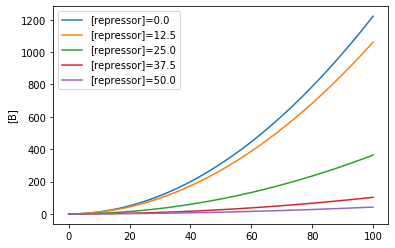

In [4]:
#Titrate the repressor and plot the result
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd

    for r_c in np.linspace(0, 50, 5):
        x0 = {str(repressible_assembly.dna):1, str(repressor):r_c}
        timepoints = np.linspace(0, 100, 100)
        R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
        plt.plot(R["time"], R["protein_reporter"], label = "[repressor]="+str(r_c))

    plt.ylabel("[B]")
    plt.legend()
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

# Example 3: A Simple Genetic Regulatory Network
In this example, the activatable_assembly will produce a repressor that represses the repressable_assembly. Notice that activatable_assembly already procues the repressor of the RepressablePromoter...so this is easy!

Species (7) = {0. rna[reporter], 1. protein[A], 2. dna[reporter], 3. protein[reporter], 4. small_molecule[activator], 5. rna[activatable_assembly], 6. dna[activatable_assembly]}
Reactions (8) = [
0. dna[reporter] --> dna[reporter] + rna[reporter]        
        proportionalhillnegative: k(protein[A], dna[reporter])=1.0*dna[reporter]/(20+protein[A]^4)
1. dna[reporter] --> dna[reporter] + rna[reporter]        
        massaction: k_f(dna[reporter])=0.01*dna[reporter]
2. rna[reporter] --> rna[reporter] + protein[reporter]        
        massaction: k_f(rna[reporter])=0.25*rna[reporter]
3. dna[activatable_assembly] --> dna[activatable_assembly] + rna[activatable_assembly]        
        proportionalhillpositive: k(small_molecule[activator], dna[activatable_assembly])=1.0*dna[activatable_assembly]*small_molecule[activator]^4/(20+small_molecule[activator]^4)
4. dna[activatable_assembly] --> dna[activatable_assembly] + rna[activatable_assembly]        
        massaction: k_f(dna[activatab

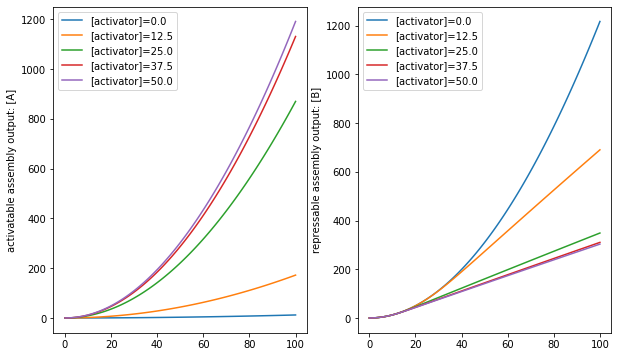

In [5]:
M = SimpleTxTlExtract(name="SimpleTxTl", parameter_file = "default_parameters.txt", components=[repressible_assembly, activatable_assembly])
CRN = M.compile_crn()
print(CRN.pretty_print())

#Titrate the activator, which in turn will automatically produce the repressor
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (10, 6))
    ax1, ax2 = plt.subplot(121), plt.subplot(122)#Create two subplots
    for a_c in np.linspace(0, 50, 5):
        x0 = {str(activatable_assembly.dna):1, str(repressible_assembly.dna):1, str(activator):a_c}
        timepoints = np.linspace(0, 100, 100)
        R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
        plt.sca(ax1)
        plt.plot(R["time"], R["protein_A"], label = "[activator]="+str(a_c))
        plt.sca(ax2)
        plt.plot(R["time"], R["protein_reporter"], label = "[activator]="+str(a_c))

    plt.sca(ax1)
    plt.ylabel("activatable assembly output: [A]")
    plt.legend()
    plt.sca(ax2)
    plt.ylabel("repressable assembly output: [B]")
    plt.legend()
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

# Example 4: RegulatedPromoter
In the below example, a CRN from RegulatedPromoter is generated. This Component models the detailed binding of regulators to the DNA and has seperate transcription rates for each regulator. It is suitable for complex models that include machinery. Regulators do not act Combinatorically.

In [6]:
#1 Regulated Promoter Needs lots of parameters!
component_parameters = {
    #Promoter Activator Binding Parameters. Note the part_id = [promoter_name]_[regulator_name]
    ('binding', 'regulated_promoter_A', 'kb'):1000, #Promoter - Activator Binding
    ('binding', "regulated_promoter_A", 'ku'):5.0, #Unbinding
    ('binding',"regulated_promoter_A", 'cooperativity'):4.0, #Cooperativity
    
    #Activated Promoter Transcription. Note the part_id = [promoter_name]_[regulator_name]
    #These regulate RNAP binding to an activated promoter and transcription
    ('transcription', 'regulated_promoter_A', 'kb'):100, #Promoter - Activator Binding
    ('transcription', "regulated_promoter_A", 'ku'):1.0, #Unbinding
    ('transcription', 'regulated_promoter_A', "ktx"): 1., #Transcription Rate
    
    #Promoter Repressor Binding Parameters. Note the part_id = [promoter_name]_[regulator_name]
    ('binding', 'regulated_promoter_R', 'kb'):1000,
    ('binding',"regulated_promoter_R", 'ku'):5.0,
    ('binding',"regulated_promoter_R", 'cooperativity'):4.0,
    
    #Repressed Promoter Transcription. Note the part_id = [promoter_name]_[regulator_name]
    #These regulate RNAP binding to a repressed promoter and transcription
    ('transcription', 'regulated_promoter_R', 'kb'):1,
    ('transcription',"regulated_promoter_R", 'ku'):100.0,
    ('transcription', 'regulated_promoter_R', "ktx"): 1.0, #Transcription Rate
    
    #Leak Parameters for transcription
    #These regulate expression of an unbound promoter
    ('transcription', 'regulated_promoter_leak', "kb"): 5.,
    ('transcription', 'regulated_promoter_leak', "ku"): 100,
    ('transcription', 'regulated_promoter_leak', "ktx"): 1.0, #Transcription Rate
}

repressor = Species("R", material_type = "protein")
activator = Species("A", material_type = "protein")
reporter = Species("reporter", material_type = "protein")

#Create a RegulatedPromoter Object named "P_reg" with regulators "activator" and "repressor"
#By Loading custom parameters into the promoter, we override the default parameters of the Mixture
P_reg = RegulatedPromoter("regulated_promoter", regulators=[activator, repressor], leak=True, parameters = component_parameters)

#Create a DNA assembly "reporter" with P_reg for its promoter
reg_reporter = DNAassembly(name="reporter", promoter=P_reg, rbs="Strong", protein = reporter)

#Use a simple TxTl model with dilution
#M = SimpleTxTlDilutionMixture(name="e coli", parameter_file = "default_parameters.txt", components=[reg_reporter])
M = TxTlExtract(name="e coli extract", parameter_file = "default_parameters.txt", components=[reg_reporter])

CRN = M.compile_crn()
print(CRN.pretty_print())

Species (15) = {0. [dna[reporter]:2x_protein[A]], 1. protein[RNAP], 2. complex[dna[reporter]:protein[RNAP]], 3. complex[[dna[reporter]:2x_protein[R]]:protein[RNAP]], 4. protein[RNAase], 5. dna[reporter], 6. complex[protein[RNAase]:rna[reporter]], 7. rna[reporter], 8. complex[[dna[reporter]:2x_protein[A]]:protein[RNAP]], 9. [dna[reporter]:2x_protein[R]], 10. protein[reporter], 11. complex[protein[Ribo]:rna[reporter]], 12. protein[Ribo], 13. protein[A], 14. protein[R]}
Reactions (12) = [
0. dna[reporter] + protein[RNAP] <--> complex[dna[reporter]:protein[RNAP]]        
        massaction: k_f(dna[reporter],protein[RNAP])=5.0*dna[reporter]*protein[RNAP]
        k_r(complex[dna[reporter]:protein[RNAP]])=100*complex[dna[reporter]:protein[RNAP]]
1. complex[dna[reporter]:protein[RNAP]] --> dna[reporter] + rna[reporter] + protein[RNAP]        
        massaction: k_f(complex[dna[reporter]:protein[RNAP]])=1.0*complex[dna[reporter]:protein[RNAP]]
2. 2.0 protein[A] + dna[reporter] <--> [dna[repor

{'dna_reporter': 1, 'protein_R': 0.0, 'protein_A': 0.0}
{'dna_reporter': 1, 'protein_R': 1.0, 'protein_A': 0.0}
{'dna_reporter': 1, 'protein_R': 2.0, 'protein_A': 0.0}
{'dna_reporter': 1, 'protein_R': 3.0, 'protein_A': 0.0}
{'dna_reporter': 1, 'protein_R': 4.0, 'protein_A': 0.0}
{'dna_reporter': 1, 'protein_R': 0.0, 'protein_A': 1.0}
{'dna_reporter': 1, 'protein_R': 1.0, 'protein_A': 1.0}
{'dna_reporter': 1, 'protein_R': 2.0, 'protein_A': 1.0}
{'dna_reporter': 1, 'protein_R': 3.0, 'protein_A': 1.0}
{'dna_reporter': 1, 'protein_R': 4.0, 'protein_A': 1.0}
{'dna_reporter': 1, 'protein_R': 0.0, 'protein_A': 2.0}
{'dna_reporter': 1, 'protein_R': 1.0, 'protein_A': 2.0}
{'dna_reporter': 1, 'protein_R': 2.0, 'protein_A': 2.0}
{'dna_reporter': 1, 'protein_R': 3.0, 'protein_A': 2.0}
{'dna_reporter': 1, 'protein_R': 4.0, 'protein_A': 2.0}
{'dna_reporter': 1, 'protein_R': 0.0, 'protein_A': 3.0}
{'dna_reporter': 1, 'protein_R': 1.0, 'protein_A': 3.0}
{'dna_reporter': 1, 'protein_R': 2.0, 'protein_A

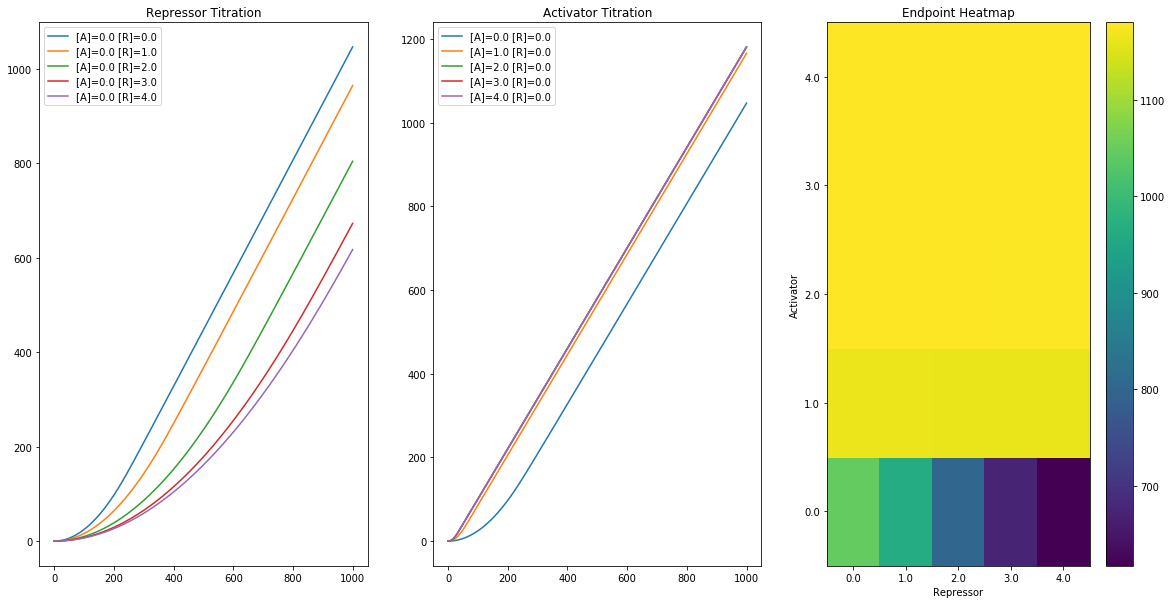

In [7]:
#Lets titrate Repressor and Activator - notice the bahvior is not combinatorial
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (20, 10))
    ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)
    N = 5 #Number of titrations
    max_titration = 4
    HM = np.zeros((N, N))
    for a_ind, a_c in enumerate(np.linspace(0, max_titration, N)):
        for r_ind, r_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {str(reg_reporter.dna):1, str(repressor):r_c, str(activator):a_c}
            print(x0)
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
            if a_ind == 0:
                plt.sca(ax1)
                plt.plot(R["time"], R[str(reporter)], label = "[A]="+str(a_c) +" [R]="+str(r_c))
            if r_ind == 0:
                plt.sca(ax2)
                plt.plot(R["time"], R[str(reporter)], label = "[A]="+str(a_c) +" [R]="+str(r_c))
            HM[a_ind, r_ind] = R[str(reporter)][len(timepoints)-1]

    plt.sca(ax1)
    plt.title("Repressor Titration")
    plt.legend()
    plt.sca(ax2)
    plt.title("Activator Titration")
    plt.legend()
    plt.sca(ax3)
    plt.title("Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("Repressor")
    plt.ylabel("Activator")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

# Example 5: Induction Model of a Ligand which Activates a Transcription Factor
In many biological circuits, small molecules (ligands) can bind to a transcription factor modulating its functionality. 

In BioCRNpyler, we will model this by creating a ChemicalComplex Component which consists of a Transcription Factor and a ligand. This the ComplexSpecies formed by by binding the transcription  will also work as the regulator (activator or repressor) of a regulated promoter. In this example, we will use RepressablePromoter. 

In the activating case, the bound form of the ChemicalComplex will induce gene expression.

In [8]:
inactive_repressor = Species("A", material_type = "protein")
ligand = Species("L", material_type = "ligand")

#Create a ChemicalComplex to model ligand-inactive_repressor bindning
activatable_repressor = ChemicalComplex([inactive_repressor, ligand])

#Other Promoters could also be used
P_repressible = RepressiblePromoter("P_repressible", repressor = activatable_repressor.get_species(), leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
repressible_assembly = DNAassembly(name="reporter", promoter=P_repressible, rbs="Strong", protein = "reporter")

M = ExpressionDilutionMixture(name="ExpressionDilutionMixture", parameter_file = "default_parameters.txt", components=[repressible_assembly, activatable_repressor])
CRN = M.compile_crn();print(CRN.pretty_print())

Species (5) = {0. protein[reporter], 1. dna[reporter], 2. complex[ligand[L]:protein[A]], 3. protein[A], 4. ligand[L]}
Reactions (8) = [
0. dna[reporter] --> dna[reporter] + protein[reporter]        
        proportionalhillnegative: k(complex[ligand[L]:protein[A]], dna[reporter])=1.0*dna[reporter]/(20+complex[ligand[L]:protein[A]]^4)
1. dna[reporter] --> dna[reporter] + protein[reporter]        
        massaction: k_f(dna[reporter])=0.01*dna[reporter]
2. protein[A] + ligand[L] <--> complex[ligand[L]:protein[A]]        
        massaction: k_f(protein[A],ligand[L])=100.0*protein[A]*ligand[L]
        k_r(complex[ligand[L]:protein[A]])=10.0*complex[ligand[L]:protein[A]]
3. protein[reporter] -->         
        massaction: k_f(protein[reporter])=0.001*protein[reporter]
4. complex[ligand[L]:protein[A]] -->         
        massaction: k_f(complex[ligand[L]:protein[A]])=0.001*complex[ligand[L]:protein[A]]
5. protein[A] -->         
        massaction: k_f(protein[A])=0.001*protein[A]
6. li

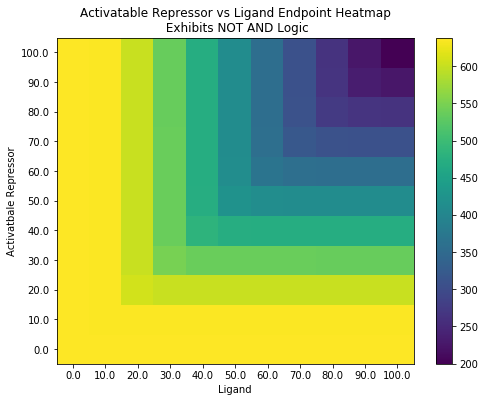

In [9]:
#Lets titrate ligand and repressor
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (8, 6))
    N = 11 #Number of titrations
    max_titration = 100
    HM = np.zeros((N, N))
    for r_ind, R_c in enumerate(np.linspace(0, max_titration, N)):
        for l_ind, L_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {str(repressible_assembly.dna):1, str(inactive_repressor):R_c, str(ligand):L_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
            HM[r_ind, l_ind] = R["protein_reporter"][len(timepoints)-1]

    plt.title("Activatable Repressor vs Ligand Endpoint Heatmap\n Exhibits NOT AND Logic")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("Ligand")
    plt.ylabel("Activatbale Repressor")
    
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

# Example 6: Induction Models of a Ligand which Deactivates a Transcription Factor
In the inactivating case, the unbound transcription factor will activate the gene and the bound form will not.

In [10]:
repressor = Species("A", material_type = "protein")
ligand = Species("L", material_type = "ligand")

#Create a ChemicalComplex to model ligand-inactive_repressor bindning
inactive_repressor = ChemicalComplex([repressor, ligand])

#Other Promoters could also be Used
P_repressible = RepressiblePromoter("P_repressible", repressor = repressor, leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
repressible_assembly = DNAassembly(name="reporter", promoter=P_repressible, rbs="Strong", protein = "reporter")

M = ExpressionDilutionMixture(name="ExpressionDilutionMixture", parameter_file = "default_parameters.txt", components=[repressible_assembly, activatable_repressor])
CRN = M.compile_crn();print(CRN.pretty_print())

Species (5) = {0. protein[A], 1. dna[reporter], 2. protein[reporter], 3. ligand[L], 4. complex[ligand[L]:protein[A]]}
Reactions (8) = [
0. dna[reporter] --> dna[reporter] + protein[reporter]        
        proportionalhillnegative: k(protein[A], dna[reporter])=1.0*dna[reporter]/(20+protein[A]^4)
1. dna[reporter] --> dna[reporter] + protein[reporter]        
        massaction: k_f(dna[reporter])=0.01*dna[reporter]
2. protein[A] + ligand[L] <--> complex[ligand[L]:protein[A]]        
        massaction: k_f(protein[A],ligand[L])=100.0*protein[A]*ligand[L]
        k_r(complex[ligand[L]:protein[A]])=10.0*complex[ligand[L]:protein[A]]
3. protein[A] -->         
        massaction: k_f(protein[A])=0.001*protein[A]
4. protein[reporter] -->         
        massaction: k_f(protein[reporter])=0.001*protein[reporter]
5. protein[A] -->         
        massaction: k_f(protein[A])=0.001*protein[A]
6. ligand[L] -->         
        massaction: k_f(ligand[L])=0.001*ligand[L]
7. complex[ligand[L]:pr

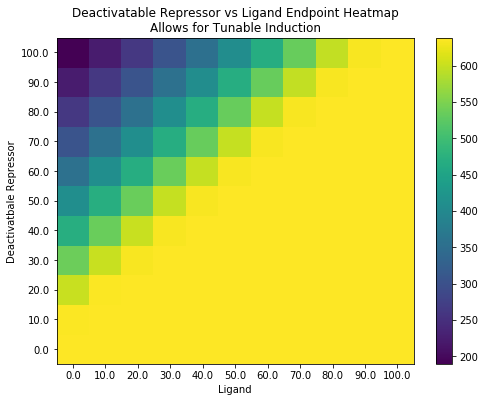

In [11]:
#Titration of ligand and repressor
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    plt.figure(figsize = (8, 6))
    N = 11 #Number of titrations
    max_titration = 100
    HM = np.zeros((N, N))
    for r_ind, R_c in enumerate(np.linspace(0, max_titration, N)):
        for l_ind, L_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {str(repressible_assembly.dna):1, str(repressor):R_c, str(ligand):L_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
            HM[r_ind, l_ind] = R["protein_reporter"][len(timepoints)-1]

    plt.title("Deactivatable Repressor vs Ligand Endpoint Heatmap\nAllows for Tunable Induction")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("Ligand")
    plt.ylabel("Deactivatbale Repressor")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

# Example 7: Modeling AND, OR, and XOR Promoters with Combinatorial Promoter
CombinatorialPromoter is a Component designed to model arbitrary combinatorial logic on a promoter. For example, a promoter with 2 transcription factor binding sites can have 4 differents states:
* Nothing bound
* just factor 1 bound
* just factor 2 bound
* factors 1 and 2 bound

In general, a promoter with $N$ binding sites has up to $2^N$ possible states. Combinatorial promoter enumerates all these states and allows for the modeller to decide which are capable of transcription and which are not. For more details on this class, see the CombinatorialPromoter example ipython notebook in the BioCRNpyler examples folder.

Below, we will use a Combinatorial Promoter to Produce OR, AND, and XOR logic with two species, $A$ and $B$ by passing in lists of the transcribable combinations of regulators to the tx_capable_list keyword.


Species (5) = {0. complex[2x_A:dna[AND]], 1. dna[AND], 2. protein[GFP], 3. complex[2x_B:dna[AND]], 4. complex[2x_A:2x_B:dna[AND]]}
Reactions (8) = [
0. dna[AND] --> dna[AND] + protein[GFP]        
        massaction: k_f(dna[AND])=0.0028125*dna[AND]
1. 2.0 A + dna[AND] <--> complex[2x_A:dna[AND]]        
        massaction: k_f(A,dna[AND])=100.0*A^2.0*dna[AND]
        k_r(complex[2x_A:dna[AND]])=10.0*complex[2x_A:dna[AND]]
2. 2.0 B + dna[AND] <--> complex[2x_B:dna[AND]]        
        massaction: k_f(B,dna[AND])=100.0*B^2.0*dna[AND]
        k_r(complex[2x_B:dna[AND]])=10.0*complex[2x_B:dna[AND]]
3. 2.0 A + complex[2x_B:dna[AND]] <--> complex[2x_A:2x_B:dna[AND]]        
        massaction: k_f(A,complex[2x_B:dna[AND]])=100.0*A^2.0*complex[2x_B:dna[AND]]
        k_r(complex[2x_A:2x_B:dna[AND]])=10.0*complex[2x_A:2x_B:dna[AND]]
4. 2.0 B + complex[2x_A:dna[AND]] <--> complex[2x_A:2x_B:dna[AND]]        
        massaction: k_f(B,complex[2x_A:dna[AND]])=100.0*B^2.0*complex[2x_A:dna[AND]]
  

C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.2.1-py3.7.egg\biocrnpyler\chemical_reaction_network.py:1106: UserWarning: The following species are uninitialized and their value has been defaulted to 0: A, B, 


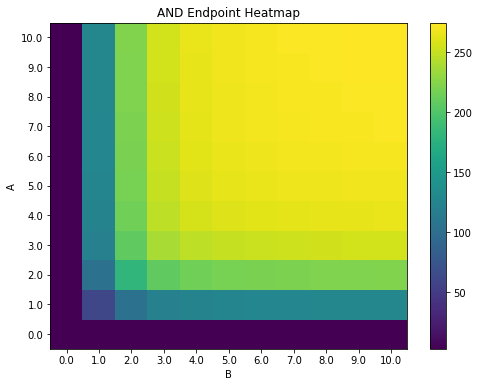

In [12]:
#AND Logic
A = Species("A") ;B = Species("B") #Inducers

#Create the Combinatorial Promoter
Prom_AND = CombinatorialPromoter("combinatorial_promoter",[A,B], tx_capable_list = [[A,B]], leak = True) #the Combination A and B can be transcribed

ANDAssembly = DNAassembly("AND",promoter=Prom_AND,rbs="medium",protein="GFP")

#Use an Expression Mixture to focus on Logic, not Transcription & Translation
M = ExpressionExtract(name="expression", parameter_file = "default_parameters.txt", components=[ANDAssembly])
CRN = M.compile_crn(); print(CRN.pretty_print())

#Lets titrate A and B
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    plt.figure(figsize = (8, 6))
    N = 11 #Number of titrations
    max_titration = 10
    HM = np.zeros((N, N))
    for a_ind, A_c in enumerate(np.linspace(0, max_titration, N)):
        for b_ind, B_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {str(ANDAssembly.dna):1, str(A):A_c, str(B):B_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
            HM[a_ind, b_ind] = R["protein_GFP"][len(timepoints)-1]

    plt.title("AND Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("B")
    plt.ylabel("A")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

Species (5) = {0. complex[2x_A:dna[OR]], 1. dna[OR], 2. protein[GFP], 3. complex[2x_B:dna[OR]], 4. complex[2x_A:2x_B:dna[OR]]}
Reactions (7) = [
0. 2.0 A + dna[OR] <--> complex[2x_A:dna[OR]]        
        massaction: k_f(A,dna[OR])=100.0*A^2.0*dna[OR]
        k_r(complex[2x_A:dna[OR]])=10.0*complex[2x_A:dna[OR]]
1. 2.0 B + dna[OR] <--> complex[2x_B:dna[OR]]        
        massaction: k_f(B,dna[OR])=100.0*B^2.0*dna[OR]
        k_r(complex[2x_B:dna[OR]])=10.0*complex[2x_B:dna[OR]]
2. 2.0 A + complex[2x_B:dna[OR]] <--> complex[2x_A:2x_B:dna[OR]]        
        massaction: k_f(A,complex[2x_B:dna[OR]])=100.0*A^2.0*complex[2x_B:dna[OR]]
        k_r(complex[2x_A:2x_B:dna[OR]])=10.0*complex[2x_A:2x_B:dna[OR]]
3. 2.0 B + complex[2x_A:dna[OR]] <--> complex[2x_A:2x_B:dna[OR]]        
        massaction: k_f(B,complex[2x_A:dna[OR]])=100.0*B^2.0*complex[2x_A:dna[OR]]
        k_r(complex[2x_A:2x_B:dna[OR]])=10.0*complex[2x_A:2x_B:dna[OR]]
4. complex[2x_A:dna[OR]] --> complex[2x_A:dna[OR]] + prot

C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.2.1-py3.7.egg\biocrnpyler\chemical_reaction_network.py:1106: UserWarning: The following species are uninitialized and their value has been defaulted to 0: A, B, 


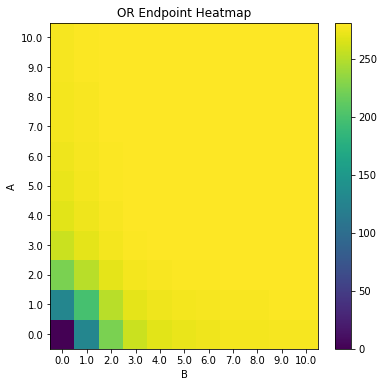

In [13]:
#Create OR Logic
Prom_OR = CombinatorialPromoter("combinatorial_promoter",[A,B], leak=False,
                              tx_capable_list = [[A,B], [A], [B]]) #the Combinations A and B or just A or just B be transcribed

ORassembly = DNAassembly("OR",promoter=Prom_OR,rbs="medium",protein="GFP")

#Use an Expression Mixture to focus on Logic, not Transcription & Translation
M = ExpressionExtract(name="expression", parameter_file = "default_parameters.txt", components=[ORassembly])
CRN = M.compile_crn()
print(CRN.pretty_print())

#Lets titrate A and B
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (6, 6))
    N = 11 #Number of titrations
    max_titration = 10
    HM = np.zeros((N, N))
    for a_ind, A_c in enumerate(np.linspace(0, max_titration, N)):
        for b_ind, B_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {str(ORassembly.dna):1, str(A):A_c, str(B):B_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
            HM[a_ind, b_ind] = R["protein_GFP"][len(timepoints)-1]
    plt.title("OR Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("B")
    plt.ylabel("A")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")

Species (5) = {0. complex[2x_A:2x_B:dna[XOR]], 1. complex[2x_A:dna[XOR]], 2. protein[GFP], 3. complex[2x_B:dna[XOR]], 4. dna[XOR]}
Reactions (6) = [
0. 2.0 A + dna[XOR] <--> complex[2x_A:dna[XOR]]        
        massaction: k_f(A,dna[XOR])=100.0*A^2.0*dna[XOR]
        k_r(complex[2x_A:dna[XOR]])=10.0*complex[2x_A:dna[XOR]]
1. 2.0 B + dna[XOR] <--> complex[2x_B:dna[XOR]]        
        massaction: k_f(B,dna[XOR])=100.0*B^2.0*dna[XOR]
        k_r(complex[2x_B:dna[XOR]])=10.0*complex[2x_B:dna[XOR]]
2. 2.0 A + complex[2x_B:dna[XOR]] <--> complex[2x_A:2x_B:dna[XOR]]        
        massaction: k_f(A,complex[2x_B:dna[XOR]])=100.0*A^2.0*complex[2x_B:dna[XOR]]
        k_r(complex[2x_A:2x_B:dna[XOR]])=10.0*complex[2x_A:2x_B:dna[XOR]]
3. 2.0 B + complex[2x_A:dna[XOR]] <--> complex[2x_A:2x_B:dna[XOR]]        
        massaction: k_f(B,complex[2x_A:dna[XOR]])=100.0*B^2.0*complex[2x_A:dna[XOR]]
        k_r(complex[2x_A:2x_B:dna[XOR]])=10.0*complex[2x_A:2x_B:dna[XOR]]
4. complex[2x_A:dna[XOR]] -->

C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.2.1-py3.7.egg\biocrnpyler\chemical_reaction_network.py:1106: UserWarning: The following species are uninitialized and their value has been defaulted to 0: A, B, 


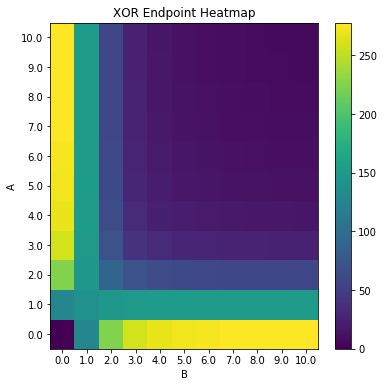

In [14]:
#Create XOR Logic
Prom_XOR = CombinatorialPromoter("combinatorial_promoter",[A,B], leak=False,
                              tx_capable_list = [[A], [B]]) #the Combinations just A or just B can be transcribed

XORassembly = DNAassembly("XOR",promoter=Prom_XOR,rbs="medium",protein="GFP")

#Use an Expression Mixture to focus on Logic, not Transcription & Translation
M = ExpressionExtract(name="expression", parameter_file = "default_parameters.txt", components=[XORassembly])
CRN = M.compile_crn()
print(CRN.pretty_print())

#Lets titrate A and B
try:
    import biocrnpyler
    import numpy as np
    import pylab as plt
    import pandas as pd
  
    plt.figure(figsize = (6, 6))
    N = 11 #Number of titrations
    max_titration = 10
    HM = np.zeros((N, N))
    for a_ind, A_c in enumerate(np.linspace(0, max_titration, N)):
        for b_ind, B_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {str(XORassembly.dna):1, str(A):A_c, str(B):B_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
            HM[a_ind, b_ind] = R["protein_GFP"][len(timepoints)-1]
    plt.title("XOR Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("B")
    plt.ylabel("A")
    
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    
except ModuleNotFoundError:
    print("Libraries needed for plotting and simulation not found.")